[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GaoyuanWu/JaxSSO/blob/main/Examples/Arch_3D.ipynb)

In [ ]:
!pip install JaxSSO
!pip install nlopt

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import JaxSSO as sso #Sensitivity analysis solver
import jax
jax.config.update("jax_enable_x64", True)

# Define the objective function and the gradient of the objective

*   The geometry, mesh
*   Build the FEA model
*   Build the SSO model


Setup: the nodes, connectivity, the load, the element's properties

In [5]:
#Definie the initial structure

#Meshes
x_span = 15 #span in x
y_span = 15 #span in y
nx, ny = (15, 15) #number of nodes in x/y
x = np.linspace(0, x_span, nx)
y = np.linspace(0, y_span, ny)
xv, yv = np.meshgrid(x, y) #meshed nodal coordinates, each in shape of (nx,ny)

#Intial nodal coordinates
n_node = nx * ny #number of nodes
x_nodes = [] #storing x nodes
y_nodes = [] #storing y nodes
z_nodes = [] #storing z nodes
design_nodes = [] #storing design nodes
non_design_nodes = [] #storing the fixed nodes, left boundary and right boundary, pinned
random_z = np.random.uniform(0,1) #random z coordinate @ design_nodes to start with
for i in range(n_node):
  x_temp = xv.ravel()[i] #flatten xv
  y_temp = yv.ravel()[i] #flatten yv
  if x_temp!=0 and x_temp!=x_span: #not on the left/right boundaries
    design_nodes.append(i)
    z_temp = random_z
  else: #on the left/right boundaries
    non_design_nodes.append(i)
    z_temp = 0
  x_nodes.append(x_temp)
  y_nodes.append(y_temp)
  z_nodes.append(z_temp)
design_nodes = np.array(design_nodes,dtype=int)
non_design_nodes = np.array(non_design_nodes,dtype=int)
design_crds = np.expand_dims(design_nodes,axis=1)
design_crds = np.hstack((design_crds,2*np.ones((design_crds.shape[0],1),dtype=int)))
x_nodes = np.array(x_nodes)
y_nodes = np.array(y_nodes)
z_nodes = np.array(z_nodes)

#Connectivity of elements
n_ele = (nx-1)*(ny) + (ny-1)*nx
cnct = np.zeros((n_ele,2),dtype=int) #connectivity info for the elements
x_ele = np.zeros((n_ele,2)) #x of the elements
y_ele = np.zeros((n_ele,2))
z_ele = np.zeros((n_ele,2))
for i in range(n_ele):
  #elements parallel to x
  if i < ((nx-1)*ny):
    ele_in_col = i%(nx-1) #which column is this element in
    ele_in_row = i//(nx-1) #which row is this element in
    cnct[i,0] = ele_in_col + ele_in_row*(nx)
    cnct[i,1] = (ele_in_col+1) + ele_in_row*(ny)
  
  #elements parallel to y
  else:
    ele_in_col = (i-(nx-1)*ny)%(nx)
    ele_in_row = (i-(nx-1)*ny)//(nx)
    cnct[i,0] = ele_in_col + ele_in_row*nx
    cnct[i,1] = ele_in_col + ele_in_row*nx + nx # one row above node i

  #Storing elements' coordinates
  x_ele[i,0] = x_nodes[cnct[i,0]]
  x_ele[i,1] = x_nodes[cnct[i,1]]
  y_ele[i,0] = y_nodes[cnct[i,0]]
  y_ele[i,1] = y_nodes[cnct[i,1]]
  z_ele[i,0] = z_nodes[cnct[i,0]]
  z_ele[i,1] = z_nodes[cnct[i,1]]

#Sectional properties-> 600x400 rectangle
h = 0.6 #height
b = 0.4 #width
E = 37900 * 10**6 #Young's modulus (pa)
G = E/(2*(1+0.3)) #Shear modolus-> E = 2G(1+mu)
Iy = b*h**3/12 #Moement of inertia in m^4
Iz = h*b**3/12 #Same, about z axis
J = Iy + Iz	#Polar moment of inertia
A = b*h #Area

#Nodal loads
load = -100000
f = np.zeros(n_node*6)
f[design_nodes*6+2] = load # nodal load in -z

Draw the initial structure

<ipython-input-6-e684171d3316>:18: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-6-e684171d3316>:19: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-6-e684171d3316>:20: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


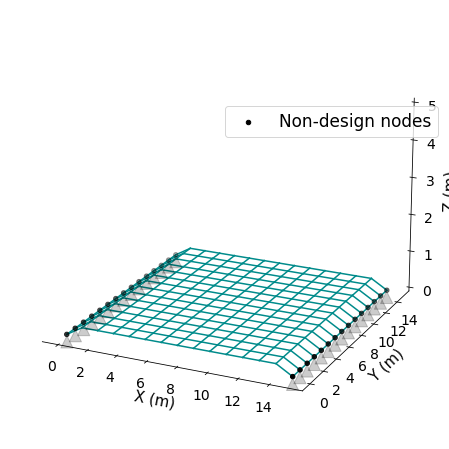

In [6]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,5)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(20, -65)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

# Create the initial model

In [7]:
################
#  SSO MODEL   #
################
#Build the model
fea_model = sso.Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):

    fea_model.node(i,x_nodes[i],y_nodes[i],z_nodes[i])
    if i not in design_nodes:
        fea_model.add_support(i,[1,1,1,1,0,1]) #Pinned, only Ry allow

#Adding elements
for i in range(n_ele):
    i_node = cnct[i,0]
    j_node = cnct[i,1]
    fea_model.beamcol(i,i_node,j_node,E,G,Iy,Iz,J,A) 

#Adding load
fea_model.add_nodal_load(f)


# Create the optimization model based on initial FEA model

In [8]:
sso_model = sso.SSO_Model.SSO_Model(fea_model,design_crds)

In [9]:
def objective(x,sso_model=sso_model):
  sso_model.update_param(x) # Update the model
  sso_model.solve() #solve FEA
  C = sso_model.Compliance() #Compliance
  sens = sso_model.Sensitivity() #sens_params
  return C,sens #sens_params

In [10]:
n_x = design_nodes.shape[0] #number of parameters
x_ini = z_nodes[design_nodes] #initial parameters 
opt = sso.Optimization.Optimization(n_x,method='GD')
opt.set_objective(objective) #objective function
opt.set_maxiter(500) #max iteration
opt.set_step_size(5e-2) #step size
opt.set_GD_normalized(True) #normalized
x_opt = opt.optimize(x_ini,log=True)

Step 0, objective = 608857.6796358796
Step 1, objective = 510525.1850110914
Step 2, objective = 429797.04303799977
Step 3, objective = 364283.5545277144
Step 4, objective = 311230.5113536249
Step 5, objective = 267999.97463795147
Step 6, objective = 232378.3165509246
Step 7, objective = 202696.73448024027
Step 8, objective = 177777.8374387125
Step 9, objective = 156782.75664281327
Step 10, objective = 139061.32035970554
Step 11, objective = 124066.2638809125
Step 12, objective = 111326.10036787415
Step 13, objective = 100442.23063911355
Step 14, objective = 91086.57092366993
Step 15, objective = 82993.88894876538
Step 16, objective = 75951.23289826783
Step 17, objective = 69787.44896805433
Step 18, objective = 64364.25961581736
Step 19, objective = 59569.184665953086
Step 20, objective = 55310.07233558821
Step 21, objective = 51510.89611979974
Step 22, objective = 48108.51395604576
Step 23, objective = 45050.15465595307
Step 24, objective = 42291.45510367898
Step 25, objective = 39794.

# Visualization

<ipython-input-11-77b41dfdce4f>:23: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-11-77b41dfdce4f>:24: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-11-77b41dfdce4f>:25: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


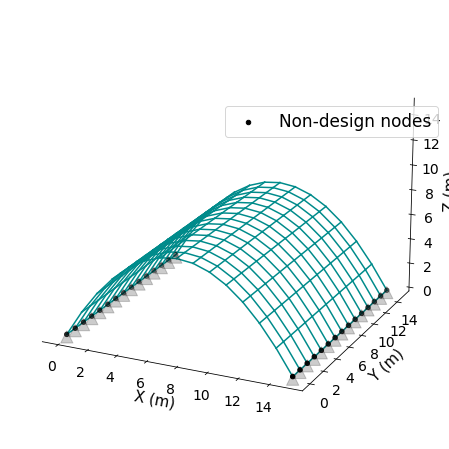

In [11]:
#Update the nodes
z_nodes[design_nodes] = x_opt
z_ele[:,0] = z_nodes[cnct[:,0]]
z_ele[:,1] = z_nodes[cnct[:,1]]

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,15)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(20, -65)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()